
# Web Traffic Time Series Forecasting

### Part2: Model Fitting, 1) ARIMA, 2) fbprophet, 3) NN. 
Useful Vedio: https://www.youtube.com/watch?v=_vQ0W_qXMxk

In [1]:
import pandas as pd
import numpy as np
from pylab import *
%matplotlib inline
import re
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns 
sns.set()
# This is used as a hack in Jupyter Notebook to make seabron plots bigger. Call before making a plot.
def setplt(r=1, c=1, w=15, h=9, **kwargs):
    f, axs = plt.subplots(r, c, figsize=(w, h), **kwargs)
    sns.despine(f, left=True, bottom=True)
    mpl.rcParams['font.family'] = 'serif'
    mpl.rcParams['axes.labelsize'] = 15
    mpl.rcParams['xtick.labelsize'] = 15
    mpl.rcParams['ytick.labelsize'] = 15
    rc('axes', linewidth=3)
    return axs
#setplt()

In [2]:
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.labelsize'] = 15
mpl.rcParams['xtick.labelsize'] = 15
mpl.rcParams['ytick.labelsize'] = 15
rc('axes', linewidth=3)
import matplotlib.ticker as ticker

In [3]:
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from pyramid.arima import auto_arima

import TSA_function
import importlib
importlib.reload(TSA_function)
from TSA_function import *

In [4]:
# readin the pre-analyzed data from part1. 
key_Page_detail=pd.read_csv('key2_EDA.csv')
train_new=pd.read_csv('train_EDA.csv')
pd_time=pd.read_csv('pd_time.csv')
time=pd_time['delta_days']

In [5]:
sum_lan=pd.DataFrame(train_new.groupby(train_new['lang']).sum())

### Look at the overall time series. 

In [6]:
median_df=pd.DataFrame(train_new.median(),columns=['visits'])
median_df['days'] = pd.to_datetime(median_df.index, format = "%Y/%m/%d")

In [7]:
rolmean = median_df['visits'].rolling(window=7).mean()
rolstd = median_df['visits'].rolling(window=7).std()

In [8]:
len(rolmean)

803

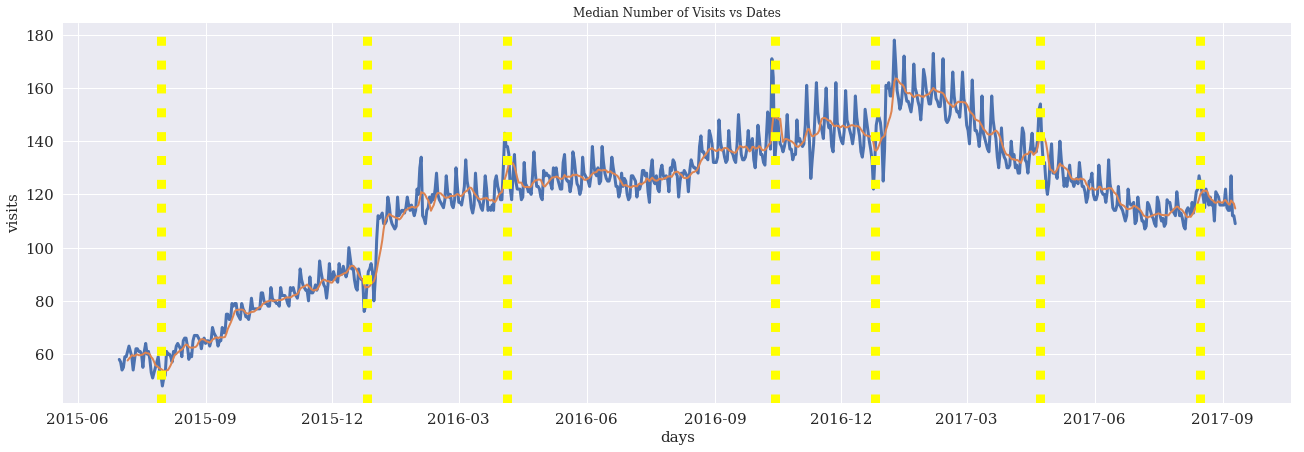

In [9]:
plt1 = setplt(w=22, h=7)
sns.lineplot(y='visits',x='days',data=median_df, palette='Blues', ax=plt1,linewidth=3.0)
sns.lineplot(x=median_df['days'],y=rolmean, palette='Oranges',linewidth = 2.0)
plt1.set_title('Median Number of Visits vs Dates')


# Create a for loop to plot specific dates using plt.axvline
for t in ['2015-07-31','2015-12-26','2016-04-05','2016-10-14','2016-12-25','2017-04-23','2017-08-16']:
    plt1.axvline(t, color='yellow', linewidth=9, linestyle=':')

Used rolmean to smooth the data and list the corresponding dips in the time series data. 

In [10]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(median_df['visits'],autolag='AIC')
print("-- Before taking the difference --")
print("ADF Statistic:", result[0])
print("p-value:", result[1])

-- Before taking the difference --
ADF Statistic: -2.371596157105554
p-value: 0.14991416416969


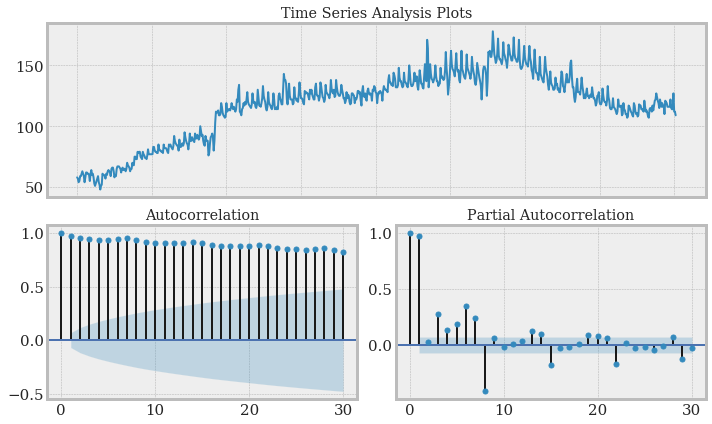

In [11]:
tsplot(median_df['visits'].dropna(),lags=30) 

In [17]:
median_df['log'] = np.log(median_df['visits']) # 7 days period 
#median_df

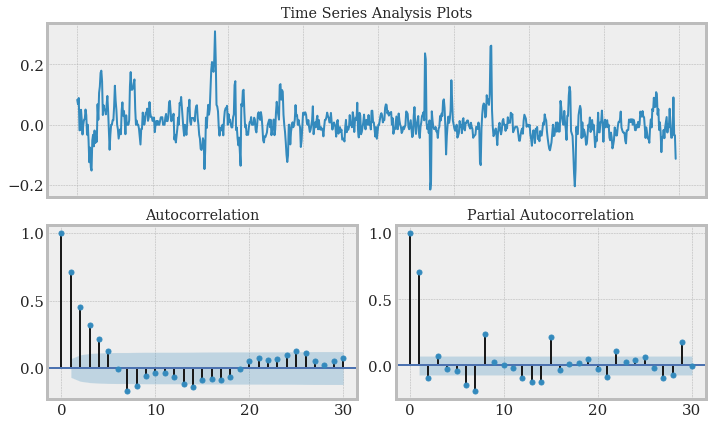

In [18]:
tsplot((median_df['log']-median_df['log'].shift(7)).dropna(),lags=30) 

In [20]:
result = adfuller((median_df['log']-median_df['log'].shift(7)).dropna(),autolag='AIC')
print("-- Before taking the difference --")
print("ADF Statistic:", result[0])
print("p-value:", result[1])

-- Before taking the difference --
ADF Statistic: -5.46960143528881
p-value: 2.4152987572261206e-06


### We get the stationary time series and now the train-test (cv) splitting. 

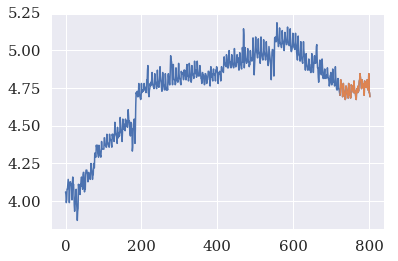

In [21]:
# 90% for training 10% for testing len(median)
y_train = median_df['log'][:723].dropna()
y_test = median_df['log'][723:]
plt.plot(time, median_df['log'])
plt.plot(time[723:],y_test)

In [23]:
from pyramid.arima import auto_arima
arima_model = auto_arima(y_train, start_p=2, start_q=1,
                           max_p=3, max_q=3, m=7,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=False,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=False, trend ='c')
print()

In [24]:
arima_model.summary().tables[0]

Dep. Variable:,y,No. Observations:,723
Model:,"SARIMAX(2, 1, 2)x(2, 1, 2, 7)",Log Likelihood,1459.485
Date:,"Tue, 30 Oct 2018",AIC,-2898.970
Time:,00:27:05,BIC,-2853.247
Sample:,0,HQIC,-2881.313
,- 723,,
Covariance Type:,opg,,


In [25]:
results = arima_model.fit(y_train)
results.summary().tables[1]

,coef,std err,z,P>|z|,[0.025,0.975]
intercept,-5.763e-05,3.27e-05,-1.765,0.078,-0.000,6.37e-06
ar.L1,0.1784,0.118,1.509,0.131,-0.053,0.410
ar.L2,0.1499,0.112,1.339,0.181,-0.070,0.369
ma.L1,-0.2579,0.104,-2.489,0.013,-0.461,-0.055
ma.L2,-0.4829,0.112,-4.320,0.000,-0.702,-0.264
ar.S.L7,-0.5836,0.236,-2.474,0.013,-1.046,-0.121
ar.S.L14,0.1159,0.076,1.529,0.126,-0.033,0.264
ma.S.L7,-0.1669,0.238,-0.703,0.482,-0.632,0.299
ma.S.L14,-0.7671,0.231,-3.315,0.001,-1.221,-0.314
sigma2,0.0010,3.08e-05,31.160,0.000,0.001,0.001


In [26]:
# make prediction
forecast = arima_model.predict(n_periods=80)

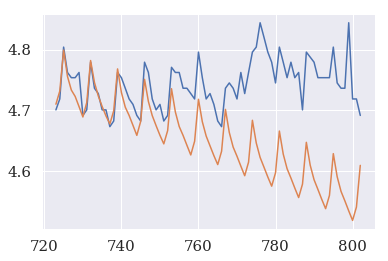

In [27]:
#plt.plot(time[:723],y_train)
plt.plot(time[723:],y_test)
plt.plot(time[723:],(forecast))

In [157]:
# invert differenced value
def inverse_difference(history, pred, interval=7):
   # print(history[-interval])
   # print(np.exp(np.log(history[-interval])+pred))
    return np.exp(pred)*history[-interval]

In [158]:
history = [x for x in median_df['visits'].iloc[0:723].values]

In [159]:
day = 1
for y in forecast:
    inverted = inverse_difference(history, y)
    #print('Day %d: %f' % (day, inverted))
    history.append(inverted)
    day += 1

In [23]:
#plot(time,median_df['log'])
#plot(time[723:],median_df['lo'][723:])
#plot(time[723:],history[723:])

In [28]:
# compute the mean square error
from math import sqrt
from sklearn.metrics import mean_squared_error
#mse = ((median[400:550] - exp(b[:-1])) ** 2).mean()
rmse=sqrt(mean_squared_error(forecast, y_test))
print('Prediction quality:({:.2f} RMSE)'.format(rmse))


Prediction quality:(0.12 RMSE)


### Different Languages

In [124]:
sum_lan_transposed = sum_lan.T # change columns to rows
sum_lan_transposed['days'] = pd.to_datetime(sum_lan_transposed.index, format = "%Y/%m/%d")

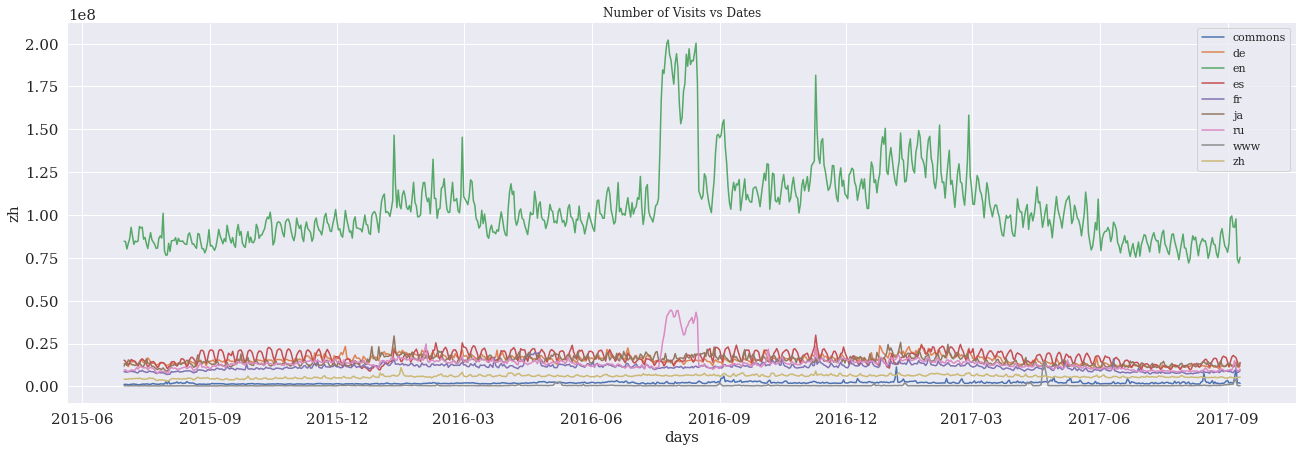

In [125]:
plt1 = setplt(w=22, h=7)
for col in sum_lan_transposed.columns[:-1]:
    sns.lineplot(y=col,x='days',data=sum_lan_transposed,ax=plt1,label=col)
plt1.set_title('Number of Visits vs Dates')
plt1.legend()

In [ ]:
data=np.log(sum_lan_transposed['de']).diff(7)
tsplot(data.dropna(),lags=30) 

Useful vedio for fbprophet 
https://www.youtube.com/watch?v=95-HMzxsghY

In [34]:
y_train_prophet = pd.DataFrame(median_df['log'].iloc[:723].values,columns=['y'])
y_train_prophet['ds'] = median_df['log'].iloc[:723].index

In [35]:
from fbprophet import Prophet
# works the best for daily model 
model=Prophet(yearly_seasonality=True)
model.fit(y_train_prophet)

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [36]:
future = model.make_future_dataframe(periods=80)
forecast = model.predict(future)

In [144]:
forecast.tail(2)

,ds,trend,trend_lower,trend_upper,yhat_lower,yhat_upper,additive_terms,additive_terms_lower,additive_terms_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,yhat
801,2017-09-09,4.733393,4.709698,4.755746,4.586008,4.695354,-0.088852,-0.088852,-0.088852,0.0,0.0,0.0,-0.022535,-0.022535,-0.022535,-0.066316,-0.066316,-0.066316,4.644542
802,2017-09-10,4.732481,4.708169,4.755251,4.659735,4.774678,-0.012916,-0.012916,-0.012916,0.0,0.0,0.0,0.051697,0.051697,0.051697,-0.064613,-0.064613,-0.064613,4.719565


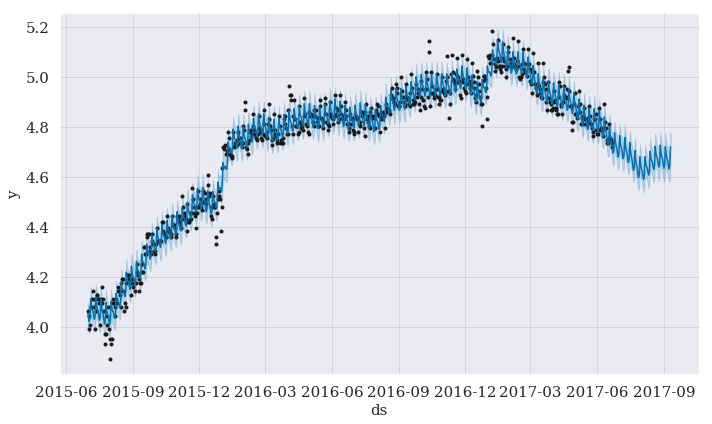

In [145]:
a=model.plot(forecast)
#plt.plot(median_df['log'].iloc[723:],color='orange')

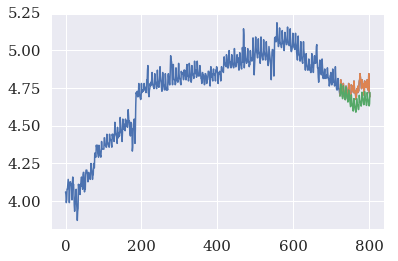

In [147]:
plot(time,median_df['log'])
plot(time[723:],median_df['log'][723:])
plot(time[723:],forecast['yhat'][723:])

In [148]:
#from fbprophet.diagnostics import cross_validation
rmse=sqrt(mean_squared_error(forecast['yhat'][723:], median_df['log'][723:]))
print('Prediction quality:({:.2f} RMSE)'.format(rmse))

Prediction quality:(0.09 RMSE)


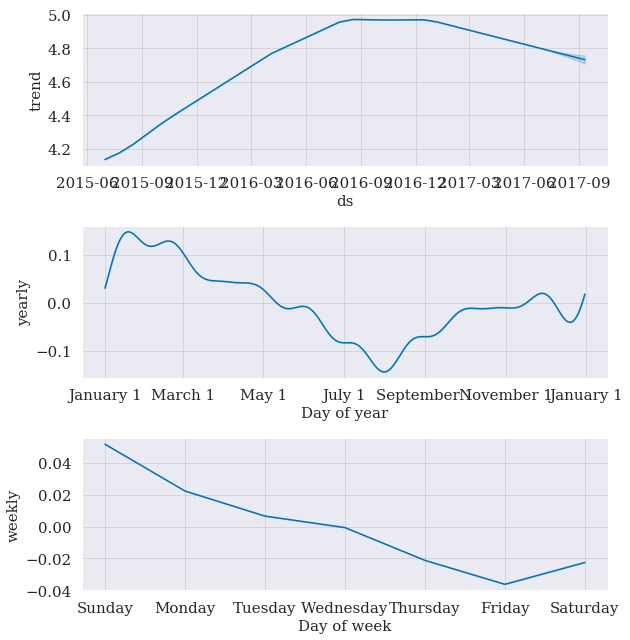

In [134]:
a=model.plot_components(forecast)

### LSTM Model

In [29]:
scaler, train_scaled, test_scaled = scale(y_train.values,y_test.values)

In [32]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [50]:
look_back = 1
trainX, trainY = create_dataset(train_scaled, look_back)
testX, testY = create_dataset(test_scaled, look_back)

In [51]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [52]:
np.shape(testX)

(78, 1, 1)

In [45]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [46]:
batch_size = 1
epoch = 1
neurons = 4

In [48]:
model = Sequential()
model.add(LSTM(neurons, batch_input_shape=(batch_size,trainX.shape[1],trainX.shape[2])))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer= 'adam')      

In [53]:
model.fit(trainX, trainY, epochs=10, batch_size=1, verbose=2)

Epoch 1/10
 - 5s - loss: 0.4792
Epoch 2/10
 - 3s - loss: 0.0583
Epoch 3/10
 - 3s - loss: 0.0367
Epoch 4/10
 - 3s - loss: 0.0346
Epoch 5/10
 - 3s - loss: 0.0327
Epoch 6/10
 - 3s - loss: 0.0314
Epoch 7/10
 - 3s - loss: 0.0306
Epoch 8/10
 - 3s - loss: 0.0298
Epoch 9/10
 - 3s - loss: 0.0292
Epoch 10/10
 - 3s - loss: 0.0287


In [62]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [73]:
np.shape(testPredict)

(78, 1)

In [72]:
np.shape(test_scaled)

(80, 1)

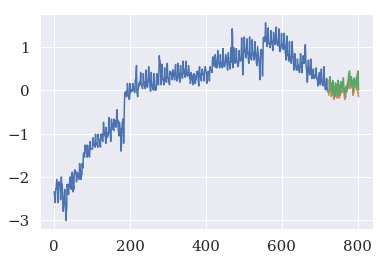

In [70]:
plt.plot(train_scaled)
plt.plot(time[723:],test_scaled)
plt.plot(np.linspace(,testPredict)